# 오토인코더 (TensorFlow 2)


In [ ]:
import tensorflow as tf                       # 텐서플로우 임포트
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트

import numpy as np
import matplotlib.pyplot as plt
 
print(tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print(tf.keras.__version__)  # 케라스 버전을 확인한다.

2.4.1
2.4.0


## MNIST 데이터셋 

In [ ]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_images의 *원래* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *원래* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)

# Normalizing the images to the range of [0., 1.]
train_images = tf.cast(train_images, tf.float32)
test_images  = tf.cast(test_images, tf.float32)

train_images = np.reshape(train_images, (len(train_images), 28,28,1)) / 255.
test_images = np.reshape(test_images, (len(test_images), 28,28,1)) /255.

# train_images /= 255
# test_images  /= 255

# train_images = np.reshape(train_images, (len(train_images), 1, 28, 28))
# test_images = np.reshape(test_images, (len(test_images), 1, 28, 28))

print('train_images의 *바뀐* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *바뀐* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)


# Print out for checking
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels.dtype)

11493376/11490434 [==============================] - 0s 0us/step
train_images의 *원래* 데이터의 shape과 dype: (60000, 28, 28) uint8
test_images의 *원래* 데이터의 shape과 dype: (10000, 28, 28) uint8
train_images의 *바뀐* 데이터의 shape과 dype: (60000, 28, 28, 1) float32
test_images의 *바뀐* 데이터의 shape과 dype: (10000, 28, 28, 1) float32
(28, 28, 1)
float32
uint8


In [ ]:
n_dim = 2

num_epochs = 10
batch_size = 100

### random_normal로 inintialization한 ae와 he_normal로 initialization한 ae를 비교하기 위해 두가지 모델을 설정하였다.

In [ ]:
enc_random = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Flatten(),    # 784 = 28 x 28
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer='random_normal'), # random_Normal을 통한  kernel_initializer 
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='random_normal'),
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer='random_normal'),
  tf.keras.layers.Dense(n_dim),  
])

dec_random = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),  
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer='random_normal'),
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer='random_normal'),
  tf.keras.layers.Dense(784, activation='sigmoid', kernel_initializer='random_normal'),   
  tf.keras.layers.Reshape(target_shape=(28, 28)),
])

ae_random = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),  
  enc_random,
  dec_random,                               
])

--------------------------------------------------------------------------------
### He Normal Initialization을 사용하여 학습을 진행한다.

- 또한 He Normal Initialization은 ReLU와 조합이 좋기 때문에 Xavier 대신에 He Normal을 사용한다.

- why ? Xavier + ReLU를 사용할 경우 layer가 깊어질 수록 weight의 분포가 0으로 치우쳐짐 (참고 https://excelsior-cjh.tistory.com/177)

<center> $W$ ~ $N(0,Var(W)$

$Var(W) = \sqrt\frac{2}{n_{in}}$    
$n_{in}:$ 이전 layer(input)의 노드 수
</center>

- Xavier + ReLu

![xavier_relu](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile5.uf.tistory.com%2Fimage%2F99585B445BB6EC2513865F)

- He + ReLU

![he_relu](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile1.uf.tistory.com%2Fimage%2F996EE64F5BB6EC4117A6BE)

In [ ]:
enc_he = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Flatten(),    # 784 = 28 x 28
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'), # He_Normal을 통한  kernel_initializer 
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(n_dim),  
])

dec_he = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),   # 주의: 반드시 1D tensor를 (ndim, )로 표현할 것
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(784, activation='sigmoid', kernel_initializer='he_normal'),   # 문제의 특성상, logit을 바로 쓰지 않고 sigmod 활성화 함수 사용함
  tf.keras.layers.Reshape(target_shape=(28, 28)),
])

ae_he = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
  enc_he,
  dec_he,                               
])

In [ ]:
y_pred_random = ae_random(train_images)
y_pred_he = ae_he(train_images)
print('input  shape:', train_images.shape)
print('output shape:', y_pred_random.shape)

input  shape: (60000, 28, 28)
output shape: (60000, 28, 28)


train_images[idx] 영상에 대한 결과 확인
* ae의 입력 / 출력 가시화


In [ ]:
# Random Normal Initialization
import ipywidgets as widgets

train_images = train_images.reshape(len(train_images),28,28)
def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)

  print(np.shape(train_images[idx]))
  plt.imshow(train_images[idx])

  plt.subplot(122)
  print(np.shape(y_pred_random[idx]))
  plt.imshow(y_pred_random[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));


interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
# He Normal Initialization
import ipywidgets as widgets

train_images = train_images.reshape(len(train_images),28,28)
def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)

  print(np.shape(train_images[idx]))
  plt.imshow(train_images[idx])

  plt.subplot(122)
  print(np.shape(y_pred_he[idx]))
  plt.imshow(y_pred_he[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));


interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 네트워크 모델 구조 확인

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_28 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 66        
Total params: 238,050
Trainable params: 238,050
Non-trainable params: 0
_________________________________________________________________


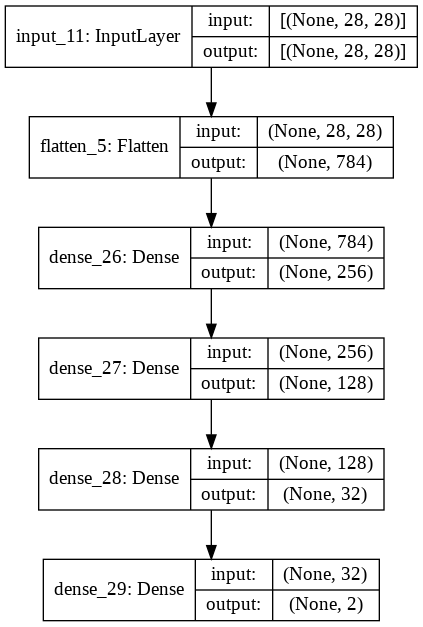

In [ ]:
enc_random.summary() # 구조는 동일하다. 
tf.keras.utils.plot_model(enc_random, 'enc.png', show_shapes=True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_31 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_32 (Dense)             (None, 784)               201488    
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28)            0         
Total params: 210,032
Trainable params: 210,032
Non-trainable params: 0
_________________________________________________________________


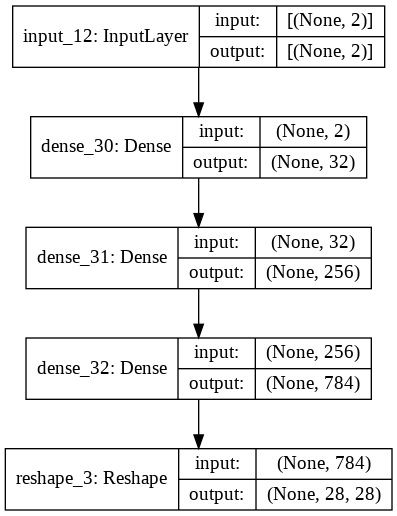

In [ ]:
dec_random.summary()
tf.keras.utils.plot_model(dec_random, 'dec.png', show_shapes=True)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 2)                 238050    
_________________________________________________________________
sequential_10 (Sequential)   (None, 28, 28)            210032    
Total params: 448,082
Trainable params: 448,082
Non-trainable params: 0
_________________________________________________________________


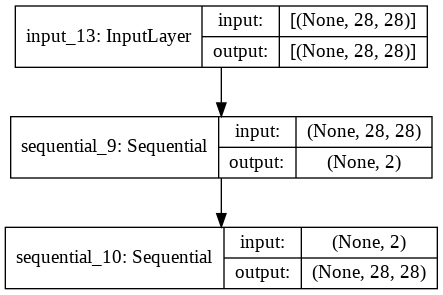

In [ ]:
ae_random.summary()
tf.keras.utils.plot_model(ae_random, 'ae.png', show_shapes=True)

## 오토인코더 인스턴스 트레이닝


In [ ]:
print(np.shape(train_images))
ae_random.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae_random.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

(60000, 28, 28)
Epoch 1/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0940 - mae: 0.1965
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0515 - mae: 0.1168
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0465 - mae: 0.1062
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0437 - mae: 0.1007
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0423 - mae: 0.0981
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0414 - mae: 0.0965
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0405 - mae: 0.0950
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0399 - mae: 0.0937
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0394 - mae: 0.0926
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0390 - mae: 0.0922


In [ ]:
print(np.shape(train_images))
ae_he.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae_he.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

(60000, 28, 28)
Epoch 1/10
600/600 [==============================] - 2s 2ms/step - loss: 0.0757 - mae: 0.1649
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0496 - mae: 0.1124
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0458 - mae: 0.1048
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0438 - mae: 0.1013
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0424 - mae: 0.0990
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0413 - mae: 0.0970
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0404 - mae: 0.0952
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0398 - mae: 0.0939
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0391 - mae: 0.0925
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0388 - mae: 0.0920


- 학습이 많이 진행될수록 Random Normal Init을 사용했때 보다 He Normal Init을 사용하면 loss, mae가 미세하게 더 낮은것을 확인할 수 있다.

트레이닝 이후 ae 함수를 다시 수행

In [ ]:
y_pred_random = ae_random(train_images)
y_pred_he = ae_he(train_images)

비지도 학습의 경우, 학습데이터를 테스트할 때 확인할 수 있음

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(131)
  plt.gca().set_title('real data')
  plt.imshow(train_images[idx])
  plt.subplot(132)
  plt.gca().set_title("Random Normal")
  plt.imshow(y_pred_random[idx])
  plt.subplot(133)
  plt.gca().set_title("He Normal")
  plt.imshow(y_pred_he[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

- idx를 움직여 보면 0,1 같은 단순한 이미지를 생성해 내는데는 두 Initialization 방법은 차이가 없지만, 위와 같이 4, 5, 8 같은 경우에 대해서는 He Normal의 경우가 보다 real data에 가까운 이미지를 생성해 내는것을 볼 수 있다.

## 인코더 / 디코더 모델을 각각 따로 함수로서 활용하기


In [ ]:
z_random = enc_random(train_images)
z_he = enc_he(train_images)
y_pred_random = dec_random(z_random)
y_pred_he = dec_he(z_he)

print(np.shape(train_images))
print(np.shape(z_random))
print(np.shape(y_pred_random))

(60000, 28, 28)
(60000, 2)
(60000, 28, 28)


## 인코딩 결과 확인 및 디코딩 결과 확인


In [ ]:
import ipywidgets as widgets

def z_show(idx):
  print("Random Normal Initialization",z_random[idx])
  print("He Normal Initialization",z_he[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

Encoding 된 latent vector를 확인해 보아도 latent vector의 값의 범위가 다른것을 알 수 있다.

인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인

In [ ]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  print(z_test)

  plt.title("Random Normal")
  img_gen_random = dec_random(z_test)
  plt.imshow(img_gen_random[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

In [ ]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  print(z_test)

  plt.title("He Normal")
  img_gen_he = dec_he(z_test)
  plt.imshow(img_gen_he[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

- idx = 28534 GT = 5인 이미지의 Enocding된 Random Normal 모델의 latent vector (-1.6458, 1.878)과 He Normal 모델의 latent vector(-0.041, -0.243)를 최대한 유사한 값의 vector로 decoding 하였더니 Random Normal 모델의 Decoder는 5보다는 8에 가까운 이미지를 생성하였고, He Normal 모델의 Decoder는 보다 5에 가까운 이미지를 생성한 것을 확인할 수 있다.


## 인코딩 결과 가시화
오토인코더의 encoder가 만들어 내는 representation인 z 값을 가시화 한다. 

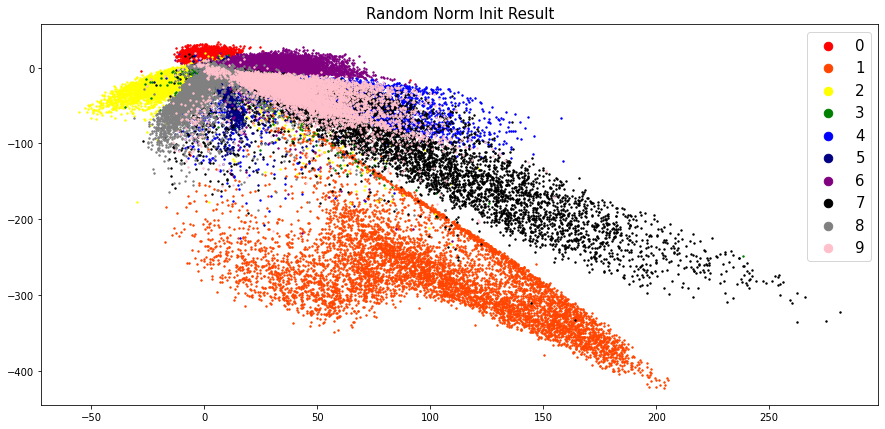

In [ ]:
# Random Normal Initialization의 결과 
import matplotlib.pyplot as plt

z_0 = z_random[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_random[train_labels==1]
z_2 = z_random[train_labels==2]
z_3 = z_random[train_labels==3]
z_4 = z_random[train_labels==4]
z_5 = z_random[train_labels==5]
z_6 = z_random[train_labels==6]
z_7 = z_random[train_labels==7]
z_8 = z_random[train_labels==8]
z_9 = z_random[train_labels==9]


plt.figure(figsize=(15,7))
plt.title('Random Norm Init Result', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

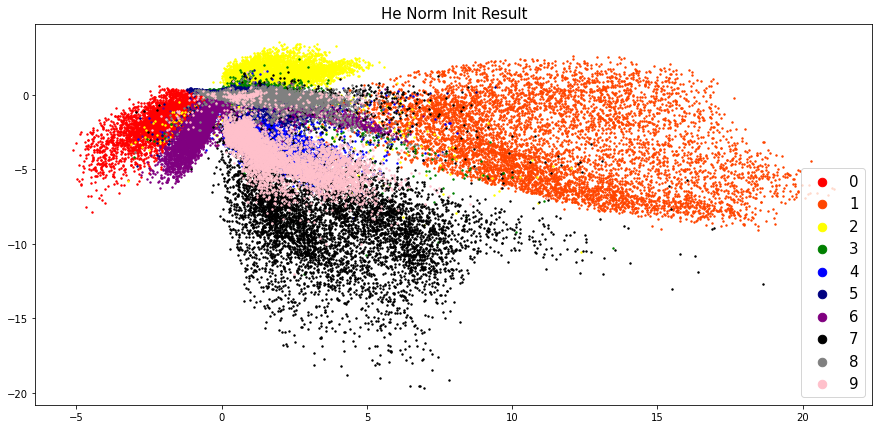

In [ ]:
# He Normal Initialization의 결과 
import matplotlib.pyplot as plt

z_0 = z_he[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_he[train_labels==1]
z_2 = z_he[train_labels==2]
z_3 = z_he[train_labels==3]
z_4 = z_he[train_labels==4]
z_5 = z_he[train_labels==5]
z_6 = z_he[train_labels==6]
z_7 = z_he[train_labels==7]
z_8 = z_he[train_labels==8]
z_9 = z_he[train_labels==9]


plt.figure(figsize=(15,7))
plt.title('He Norm Init Result', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- 두 모델의 결과를 살펴보면 두 경우다 discriminative 하다고 보기 힘들다. 하지만, 두 모델 끼리 비교를 한다면 He Normal Initialization이 Random Normal Initialization보다 discriminative 하다고 볼 수 있다. 

- 결론적으로 두 모델 다 encoder가 label별로 discriminative 한 representation을 만들지 못했음으로 latent vector를 4차원으로 늘려 encoder가 생성한 representation에 대하여 비교를 해 보겠다.

### Latent Vector = 4 (Random Norm Init, He Norm Init 비교)

In [ ]:
enc_random_4 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Flatten(),    # 784 = 28 x 28
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer='random_normal'), # random_Normal을 통한  kernel_initializer 
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='random_normal'),
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer='random_normal'),
  tf.keras.layers.Dense(4),  #latent vector = 4차원
])

dec_random_4 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(4,)),  
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer='random_normal'),
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer='random_normal'),
  tf.keras.layers.Dense(784, activation='sigmoid', kernel_initializer='random_normal'),   
  tf.keras.layers.Reshape(target_shape=(28, 28)),
])

ae_random_4 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),  
  enc_random_4,
  dec_random_4,                               
])

In [ ]:
enc_he_4 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Flatten(),    # 784 = 28 x 28
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'), # random_Normal을 통한  kernel_initializer 
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(4),  #latent vector = 4차원
])

dec_he_4 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(4,)),  
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
  tf.keras.layers.Dense(784, activation='sigmoid', kernel_initializer='he_normal'),   
  tf.keras.layers.Reshape(target_shape=(28, 28)),
])

ae_he_4 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),  
  enc_he_4,
  dec_he_4,                               
])

In [ ]:
y_pred_random_4 = ae_random_4(train_images)
y_pred_he_4 = ae_he_4(train_images)
print('input  shape:', train_images.shape)
print('output shape:', y_pred_random_4.shape)

input  shape: (60000, 28, 28)
output shape: (60000, 28, 28)


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_41 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_42 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 132       
Total params: 238,116
Trainable params: 238,116
Non-trainable params: 0
_________________________________________________________________


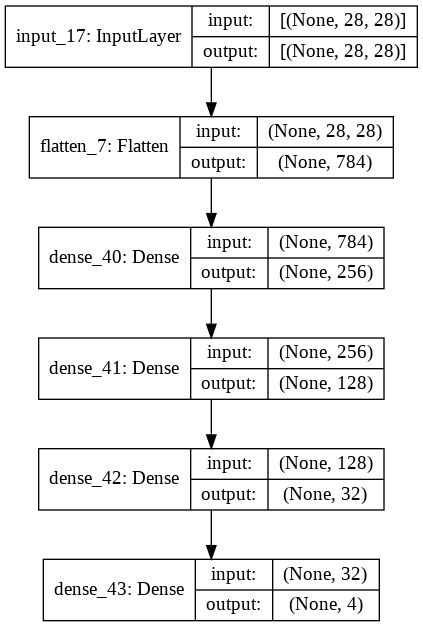

In [ ]:
enc_random_4.summary() # 구조는 동일하다. 
tf.keras.utils.plot_model(enc_random_4, 'enc.png', show_shapes=True)

In [ ]:
print(np.shape(train_images))
ae_random_4.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae_random_4.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

(60000, 28, 28)
Epoch 1/10
600/600 [==============================] - 2s 2ms/step - loss: 0.0913 - mae: 0.1900
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0425 - mae: 0.0986
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0353 - mae: 0.0844
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0333 - mae: 0.0806
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0322 - mae: 0.0783
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0313 - mae: 0.0765
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0304 - mae: 0.0749
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0299 - mae: 0.0739
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0295 - mae: 0.0730
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0288 - mae: 0.0717


In [ ]:
print(np.shape(train_images))
ae_he_4.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae_he_4.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

(60000, 28, 28)
Epoch 1/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0685 - mae: 0.1506
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0374 - mae: 0.0884
Epoch 3/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0343 - mae: 0.0824
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0327 - mae: 0.0792
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0314 - mae: 0.0767
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0304 - mae: 0.0745
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0297 - mae: 0.0732
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0291 - mae: 0.0720
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0286 - mae: 0.0711
Epoch 10/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0283 - mae: 0.0706


- latent vector ndim =2 일 경우와 동일하게 학습을 진행하였다. 그 결과를 확인해 보면 latent vector ndim = 4일 경우가 ndim = 2 일 경우보다 loss가 0.01, mae가 0.02 보다 낮은 것을 확인할 수 있다. 즉 latent vector, encoding 된 이미지의 차원이 커질 수록 보다 좋은 표현 학습이 가능한 것을 확인할 수 있다.

- 또한 ndim = 4 일 경우 he normal initialization 모델이 random normal 보다 loss, mae가 낮은 것을 확인 할 수 있다.

트레이닝 이후 ae함수 다시 수행 (ndim =4)

In [ ]:
y_pred_random_4 = ae_random_4(train_images)
y_pred_he_4 = ae_he_4(train_images)


In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(131)
  plt.gca().set_title('real data')
  plt.imshow(train_images[idx])
  plt.subplot(132)
  plt.gca().set_title("Random Normal")
  plt.imshow(y_pred_random_4[idx])
  plt.subplot(133)
  plt.gca().set_title("He Normal")
  plt.imshow(y_pred_he_4[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

- 또한 위의 ndim=2인 모델들과 ndim=4인 모델들을 idx = 41664 에 대한 결과를 비교해보면 기존 ndim=2 random normal 모델은 GT인 4에 대해서 제대로 생성하지 못하였는데, ndim = 4 random normal 모델이 보다 좋은 결과를 나타냄을 확인할 수 있다.

### 인코더 / 디코더 모델을 각각 따로 함수로서 활용하기

In [ ]:
z_random_4 = enc_random_4(train_images)
z_he_4 = enc_he_4(train_images)
y_pred_random_4 = dec_random_4(z_random_4)
y_pred_he_4 = dec_he_4(z_he_4)

print(np.shape(train_images))
print(np.shape(z_random_4))
print(np.shape(y_pred_random_4))

(60000, 28, 28)
(60000, 4)
(60000, 28, 28)


In [ ]:
import ipywidgets as widgets

def z_show(idx):
  print("Random Normal Initialization",z_random_4[idx])
  print("He Normal Initialization",z_he_4[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-25.0, max=25.0)
v=widgets.FloatSlider(min=-25.0, max=25.0)
z=widgets.FloatSlider(min=-25.0, max=25.0)
w=widgets.FloatSlider(min=-25.0, max=25.0)

ui = widgets.HBox([u,v,z,w])

def z_test(u, v, z, w):
  z_test = np.array([[u,v,z,w]])  
  print(z_test)

  plt.title("Random Normal")
  img_gen_random_4 = dec_random_4(z_test)
  plt.imshow(img_gen_random_4[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v, 'z':z, 'w':w})

display(ui, out)

Output()

In [ ]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-25.0, max=25.0)
v=widgets.FloatSlider(min=-25.0, max=25.0)
z=widgets.FloatSlider(min=-25.0, max=25.0)
w=widgets.FloatSlider(min=-25.0, max=25.0)

ui = widgets.HBox([u,v,z,w])

def z_test(u, v, z, w):
  z_test = np.array([[u,v,z,w]])  
  print(z_test)

  plt.title("He Normal")
  img_gen_he_4 = dec_he_4(z_test)
  plt.imshow(img_gen_he_4[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v, 'z':z, 'w':w})

display(ui, out)

Output()

- ndim = 2 모델의 Encoding된 latent vecotor 결과 (idx = 28534) 에 맞추어 ndim = 4 모델의 Encoding latent vector를 구하여 비슷한 값으로 random vector를 생성하여 decoding 한 결과를 비교해 보았다.

- ndim = 2 모델로 decoding 한 결과가 보다 좋은 이미지를 생성한 것을 확인할 수 있다. 하지만 2개의 값을 조절하여 decoding한 결과와 4개의 값을 조절하여 decoding한 결과와 비교하기에는 어려우며, 이 실험을 통해 ndim을 수정하여도 He Normal Initialzation 모델이 더 좋은 이미지를 생성했음을 확인할 수 있다.

### 인코딩 결과 가시화

- 위의 ndim = 2일 경우에는 각각에 축에 해당하는 값을 통하여 Encoding 결과를 가시화 할 수 있지만 ndim = 4인 경우는 가시화를 하지 못하기 때문에 tsne를 통해 ndim=2으로 축소하여 결과를 확인한다.

### TSNE

In [ ]:
from sklearn.manifold import TSNE      # sklearn에서 제공하는 TSNE를 사용한다

tsne = TSNE(n_components = 2)
transformed_z_random_4  = tsne.fit_transform(z_random_4)

In [ ]:
tsne = TSNE(n_components = 2)
transformed_z_he_4  = tsne.fit_transform(z_he_4)

In [ ]:
print(transformed_z_random_4.shape)
print(transformed_z_he_4.shape) #2차원으로 축소되었다.

(60000, 2)
(60000, 2)


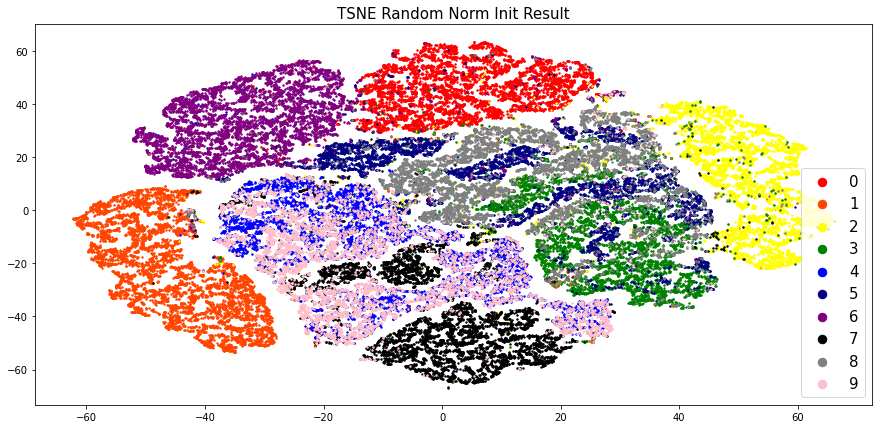

In [ ]:
# Random Normal Initialization의 결과 
import matplotlib.pyplot as plt

z_0 = transformed_z_random_4[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = transformed_z_random_4[train_labels==1]
z_2 = transformed_z_random_4[train_labels==2]
z_3 = transformed_z_random_4[train_labels==3]
z_4 = transformed_z_random_4[train_labels==4]
z_5 = transformed_z_random_4[train_labels==5]
z_6 = transformed_z_random_4[train_labels==6]
z_7 = transformed_z_random_4[train_labels==7]
z_8 = transformed_z_random_4[train_labels==8]
z_9 = transformed_z_random_4[train_labels==9]


plt.figure(figsize=(15,7))
plt.title('TSNE Random Norm Init Result', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

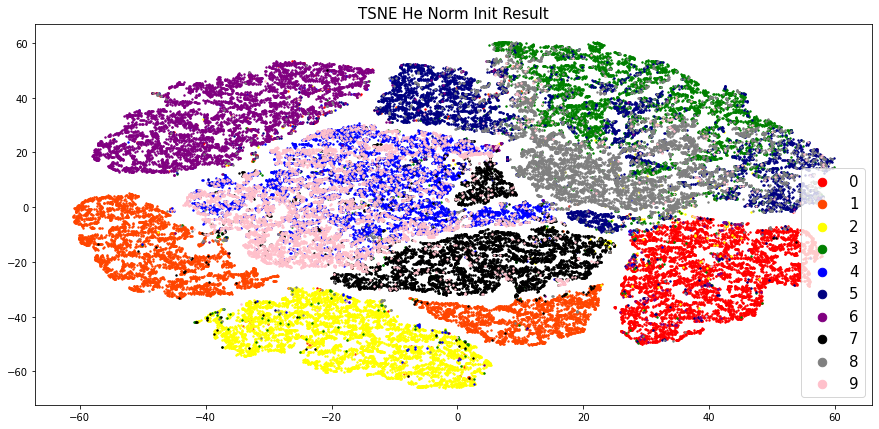

In [ ]:
# He Normal Initialization의 결과 
import matplotlib.pyplot as plt

z_0 = transformed_z_he_4[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = transformed_z_he_4[train_labels==1]
z_2 = transformed_z_he_4[train_labels==2]
z_3 = transformed_z_he_4[train_labels==3]
z_4 = transformed_z_he_4[train_labels==4]
z_5 = transformed_z_he_4[train_labels==5]
z_6 = transformed_z_he_4[train_labels==6]
z_7 = transformed_z_he_4[train_labels==7]
z_8 = transformed_z_he_4[train_labels==8]
z_9 = transformed_z_he_4[train_labels==9]


plt.figure(figsize=(15,7))
plt.title('TSNE He Norm Init Result', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- ndim = 4 -> tsne 한 두 모델의 결과를 살펴보면 두 경우다 ndim=2 모델보다 discriminative 하다고 볼 수 있다. 

- 또한 initialization 종류에 따른 Encoding 결과를 확인해보면 Random Norm 보다 He Norm의 모델이 보다 discriminative한 representation z를 학습을 더 잘한 것을 확인 할 수 있다.

## 디코더를 이용한 Generative Model 구성

In [ ]:
z = np.array([[-0, 1], 
              [80, -100], 
              [200, -350]
             ])

result = dec_random(z)

print(z.shape)
print(result.shape)

(3, 2)
(3, 28, 28)


결과 가시화

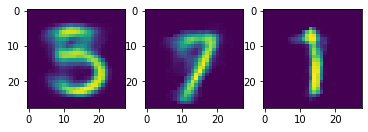

In [ ]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt

plt.subplot(131)
plt.imshow(result[0])
plt.subplot(132)
plt.imshow(result[1])
plt.subplot(133)
plt.imshow(result[2])

plt.show()

In [ ]:
z = np.array([[-4, -3], 
              [2, -6], 
              [10, -3]
             ])

result = dec_he(z)

print(z.shape)
print(result.shape)

(3, 2)
(3, 28, 28)


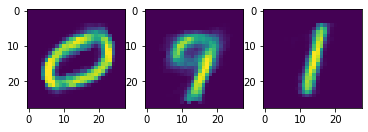

In [ ]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt

plt.subplot(131)
plt.imshow(result[0])
plt.subplot(132)
plt.imshow(result[1])
plt.subplot(133)
plt.imshow(result[2])

plt.show()

- ndim = 2 random norm init모델의 z공간의 임의의 위치를 sampling 한 후 decoder의 결과를 확인해 보면, 7과 1 같은 경우 명확하게 다른 분포들과 떨어져 있는것을 확인할 수 있다. 1번째 결과는 5,8로 보이는데 위의 encoder 시각화를 확인해 보면 0, 5, 8 분포가 겹쳐저 있는것을 확인할 수 있다.

- he norm init 모델의 z공간을 sampling한 후 결과를 확인해 보면 0, 1 같은 경우는 위의 경우와 동일하게 명확하게 다른 분포들과 겹처 있는 부분이 적고, 2번째 결과인 7,9로 보이는 z값을 encoder 시각화를 확인해 보면 7,9의 분포가 겹쳐있는것을 확인할 수 있다.

- 즉, 의미 있는 이미지를 만들기 위해서는 다른 분포들과 명확하게 분리 되어야 하고 독립적으로 자신만의 군집을 이룰 경우 의미 있는 이미지를 만들 수 있다. 이렇게 될 경우 z 값에 대하여 해석이 가능해진다.

- n dim = 4의 모델들은 축소한 z 값임으로 확인이 불가능하다는 것이 아쉽다.

#### 결론 : 

- latent vector의 사이즈가 동일하게 autoencoder를 학습시킬 경우 Random Normal initializatio 보다 He Normal initialization이 학습이 잘 되었을 뿐만 아니라 더욱 discriminative한 representation을 만들어 냈음을 확인했다. 

- AutoEncoder의 latent vector 차원이 클 수록, 작은 경우보다 데이터의 representation을 보다 잘 학습을 하고, discriminative한 representation을 만들어 낼 수 있다.

In [ ]:
ae_random.optimizer.get_config() # 모든 모델의 조건은 동일하다.

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [ ]:
n_dim = 2

num_epochs = 10
batch_size = 100

In [ ]:
""" 
Convolutional AutoEncoder model 구축 
"""

conv_enc = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)), # input_shape = (28,28,1)
    # 앞에서 실험한 Dense ae구조와 비슷하게 filters를 준다. 또한 output에 대하여 이미지 size가 좁아지도록 stride를 2로 설정한다.                                    
    tf.keras.layers.Conv2D(filters = 256, kernel_size=(3,3), strides = (2,2), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides = (2,2), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = n_dim, kernel_size=(4,4), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.GlobalAveragePooling2D()
])

conv_dec = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_dim,)),
    tf.keras.layers.Reshape(target_shape=(1,1,2)),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=(4,4), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2DTranspose(128, kernel_size=(3,3), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2DTranspose(256, kernel_size=(3,3), strides = (2,2), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=(4,4), strides = (2,2), padding='valid',  kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('sigmoid')
                                  
])

conv_ae = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    conv_enc,
    conv_dec                          
])

In [ ]:
conv_enc.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 13, 13, 256)       2560      
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
activation_7 (Activation)    (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 128)         295040    
_________________________________________________________________
batch_normalization_8 (Batch (None, 6, 6, 128)         512       
_________________________________________________________________
activation_8 (Activation)    (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 32)         

In [ ]:
conv_dec.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 1, 2)           0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 32)          1056      
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 4, 32)          128       
_________________________________________________________________
activation_10 (Activation)   (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 6, 6, 128)         36992     
_________________________________________________________________
batch_normalization_11 (Batc (None, 6, 6, 128)         512       
_________________________________________________________________
activation_11 (Activation)   (None, 6, 6, 128)        

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 2)                 337186    
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28, 1)         338981    
Total params: 676,167
Trainable params: 674,501
Non-trainable params: 1,666
_________________________________________________________________


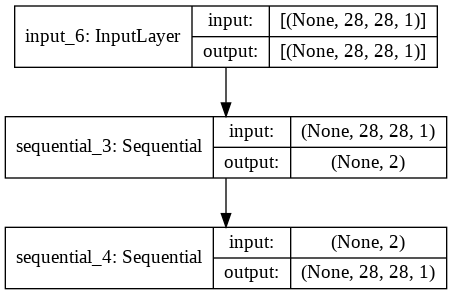

In [ ]:
conv_ae.summary() # 구조는 동일하다. 
tf.keras.utils.plot_model(conv_ae, 'conv_ae.png', show_shapes=True)

In [ ]:
y_pred_conv = conv_ae.predict(train_images,batch_size = 1024)
print('input  shape:', train_images.shape)
print('output shape:', y_pred_conv.shape)

input  shape: (60000, 28, 28, 1)
output shape: (60000, 28, 28, 1)


In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.gca().set_title('real data')
  plt.imshow(np.reshape(train_images[idx],(28,28)))
  plt.subplot(122)
  plt.gca().set_title("Conv AE")
  plt.imshow(np.reshape(y_pred_conv[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
 """
compile, fit 함수 작성 및 실행
"""
print(np.shape(train_images))
conv_ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

conv_ae.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

(60000, 28, 28, 1)
Epoch 1/10
600/600 [==============================] - 11s 17ms/step - loss: 0.1569 - mae: 0.3652
Epoch 2/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0869 - mae: 0.2576
Epoch 3/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0648 - mae: 0.2065
Epoch 4/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0551 - mae: 0.1773
Epoch 5/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0501 - mae: 0.1590
Epoch 6/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0468 - mae: 0.1457
Epoch 7/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0449 - mae: 0.1366
Epoch 8/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0434 - mae: 0.1288
Epoch 9/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0423 - mae: 0.1224
Epoch 10/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0416 - mae: 0.1173


In [ ]:
"""
학습된 Convolutional Autoencoder 통과
"""

y_pred_conv_ae = conv_ae.predict(train_images, batch_size = 1024)


# encoder , decoder 다른 함수로 사용을 위함 
z_conv = conv_enc.predict(train_images, batch_size = 1024)
y_pred_conv = conv_dec.predict(z_conv, batch_size = 1024)
print(np.shape(train_images))
print(np.shape(z_conv))
print(np.shape(y_pred_conv))

(60000, 28, 28, 1)
(60000, 2)
(60000, 28, 28, 1)


In [ ]:
"""
Convolutional AE 결과 확인
"""



def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.gca().set_title('real data')
  plt.imshow(np.reshape(train_images[idx],(28,28)))
  plt.subplot(122)
  plt.gca().set_title("Conv AE")
  plt.imshow(np.reshape(y_pred_conv_ae[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

- convolutional layer를 이용해서 학습을 진행한 결과를 확인해 보면 어느 정도 유사한 이미지를 생성해 내는것을 확인할 수 있다. 하지만 결과를 잘 살펴보면 전체적으로 색이 균등한게 아니라 한 군데에만 색이 뚜렷한 이미지를 생성해 내는데 이는 image size가 줄어들지만, image에 대한 정보가 충분히 channels에 저장되지 못한다는것을 알 수 있다. 따라서 다음 실험에는 image의 size가 줄어듬에 따라 output에 대한 channels를 (즉 num of filter) 늘리는 모델을 구성하여 학습을 진행해보겠다.

In [ ]:
def z_show(idx):
  print("Conv AutoEncoder",z_conv[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  print(z_test)

  plt.title("Convolutional Decoder")
  img_gen_conv = conv_dec(z_test)
  plt.imshow(np.reshape(img_gen_conv[0],(28,28)))
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

- Encoder에서  Ground Truth : 3 인 경우에 대해 Encoding된 z값과 비슷한 값을 decoding 했을 경우 3과 유사한 이미지가 나오는 것을 확인할 수 있다. 하지만 하단부의 값이 유독 높은 것을 확인할 수 있다.

## 인코딩 결과 가시화

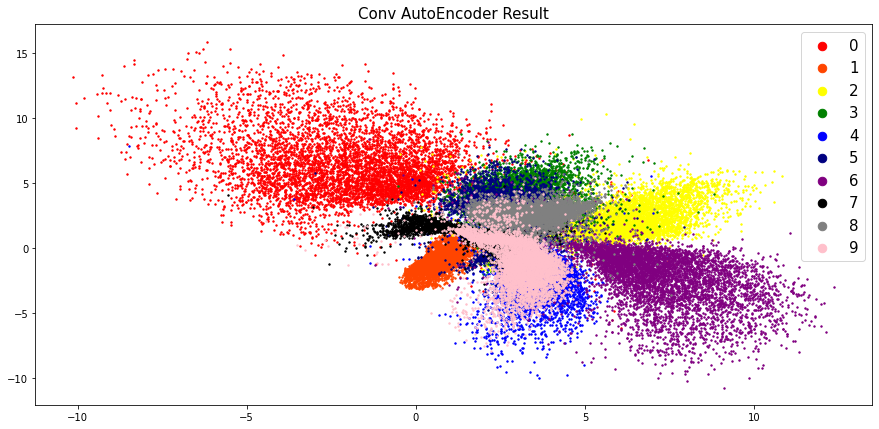

In [ ]:
import matplotlib.pyplot as plt

z_0 = z_conv[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_conv[train_labels==1]
z_2 = z_conv[train_labels==2]
z_3 = z_conv[train_labels==3]
z_4 = z_conv[train_labels==4]
z_5 = z_conv[train_labels==5]
z_6 = z_conv[train_labels==6]
z_7 = z_conv[train_labels==7]
z_8 = z_conv[train_labels==8]
z_9 = z_conv[train_labels==9]


plt.figure(figsize=(15,7))
plt.title('Conv AutoEncoder Result', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- Convolutional AE의 z vector에 대해 시각화를 해보면, 위에서 Dense AE보다는 했을 경우 보다는 discriminative한 학습을 했다고 볼 수 있다. 하지만 여전히 0,2,6,1 을 제외하고는 분포들이 겹쳐 있는것을 확인할 수 있는데, 이를 해결하기 위해 다양한 실험을 진행해 보았다. 

### 1. image의 공간적인 학습을 위해 channels를 늘려가는 방향의 Convolutional AE를 만들어보자

In [ ]:
conv_enc_1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)), # input_shape = (28,28,1)                                 
    tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), strides = (2,2), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides = (2,2), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = 256, kernel_size=(3,3), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = n_dim, kernel_size=(4,4), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.GlobalAveragePooling2D()
])

conv_dec_1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_dim,)),
    tf.keras.layers.Reshape(target_shape=(1,1,2)),
    tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2DTranspose(128, kernel_size=(3,3), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides = (2,2), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=(4,4), strides = (2,2), padding='valid',  kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('sigmoid')
                                  
])

conv_ae_1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    conv_enc_1,
    conv_dec_1                          
])

In [ ]:
conv_enc_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 13, 13, 32)        320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
activation_21 (Activation)   (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 6, 128)         36992     
_________________________________________________________________
batch_normalization_22 (Batc (None, 6, 6, 128)         512       
_________________________________________________________________
activation_22 (Activation)   (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 256)        

In [ ]:
conv_dec_1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1, 1, 2)           0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 4, 4, 256)         8448      
_________________________________________________________________
batch_normalization_24 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_24 (Activation)   (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 6, 6, 128)         295040    
_________________________________________________________________
batch_normalization_25 (Batc (None, 6, 6, 128)         512       
_________________________________________________________________
activation_25 (Activation)   (None, 6, 6, 128)       

In [ ]:
y_pred_conv_1 = conv_ae_1.predict(train_images,batch_size = 1024)
print('input  shape:', train_images.shape)
print('output shape:', y_pred_conv_1.shape)

input  shape: (60000, 28, 28, 1)
output shape: (60000, 28, 28, 1)


In [ ]:

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.gca().set_title('real data')
  plt.imshow(np.reshape(train_images[idx],(28,28)))
  plt.subplot(122)
  plt.gca().set_title("Conv AE")
  plt.imshow(np.reshape(y_pred_conv_1[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
## 학습 

print(np.shape(train_images))
conv_ae_1.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

conv_ae_1.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

(60000, 28, 28, 1)
Epoch 1/10
600/600 [==============================] - 12s 17ms/step - loss: 0.1582 - mae: 0.3676
Epoch 2/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0872 - mae: 0.2584
Epoch 3/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0645 - mae: 0.2068
Epoch 4/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0548 - mae: 0.1774
Epoch 5/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0498 - mae: 0.1584
Epoch 6/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0465 - mae: 0.1446
Epoch 7/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0447 - mae: 0.1346
Epoch 8/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0434 - mae: 0.1270
Epoch 9/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0424 - mae: 0.1211
Epoch 10/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0416 - mae: 0.1163


- 이전의 conv ae 와 비교해 보았을 때, loss, mae 부분에 대해서 이 모델이 성능이 조금 더 나아졌다.

In [ ]:
"""
학습된 Convolutional Autoencoder 통과
"""

y_pred_conv_ae_1 = conv_ae_1.predict(train_images, batch_size = 1024)


# encoder , decoder 다른 함수로 사용을 위함 
z_conv_1 = conv_enc_1.predict(train_images, batch_size = 1024)
y_pred_conv_1 = conv_dec_1.predict(z_conv_1, batch_size = 1024)
print(np.shape(train_images))
print(np.shape(z_conv_1))
print(np.shape(y_pred_conv_1))

(60000, 28, 28, 1)
(60000, 2)
(60000, 28, 28, 1)


In [ ]:
"""
Convolutional AE 결과 확인
"""



def io_imshow(idx):
  plt.figure(figsize = (15,7))
  print('GT label:', train_labels[idx])
  plt.subplot(131)
  plt.gca().set_title('real data')
  plt.imshow(np.reshape(train_images[idx],(28,28)))
  plt.subplot(132)
  plt.gca().set_title("Conv AE(Encoder filters : 32 -> 128 -> 256")
  plt.imshow(np.reshape(y_pred_conv_ae_1[idx],(28,28)))
  plt.subplot(133)
  plt.gca().set_title("Conv AE(Encoder filters : 256->128->32)")
  plt.imshow(np.reshape(y_pred_conv_ae[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

- filters = 32 -> 128 -> 256 -> 2 -> 256 -> 128 -> 32 -> 1 로 만든 Convolutional AE를 확인해보면, 이전 Convoultional AE와 동일한 idx의 output을 확인해 보면 3번째 이미지 는 3의 하단 부분 한 군데에 focus 되어 있어 값이 큰 것을 확인할 수 있는데, 가운데 이미지를 확인해보면 오른쪽 이미지와 다르게 전체적으로 값이 균등한 것을 확인할 수 있다. 즉, 한 부분을 보는것이 아니라 전체에 대한 representation학습이 더 잘된것을 확인할 수 있다.

In [ ]:
def z_show(idx):
  print("Conv AutoEncoder",z_conv_1[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
u=widgets.FloatSlider(min=-10.0, max=10.0)
v=widgets.FloatSlider(min=-10.0, max=10.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  print(z_test)
  
  plt.title("Convolutional Decoder (filters : 256 -> 128 -> 32 -> 1)")
  img_gen_conv_1 = conv_dec_1(z_test)
  plt.imshow(np.reshape(img_gen_conv_1[0],(28,28)))
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

- Encoder에서 Ground Truth : 9 인 경우에 대해 Encoding된 z값과 비슷한 값을 decoding 했을 경우 9과 유사한 이미지가 나오는 것을 확인할 수 있다. 또한 이전 Convolutional AE보다 전체적인 영역에서 decoding을 하는것을 확인할 수 있다.

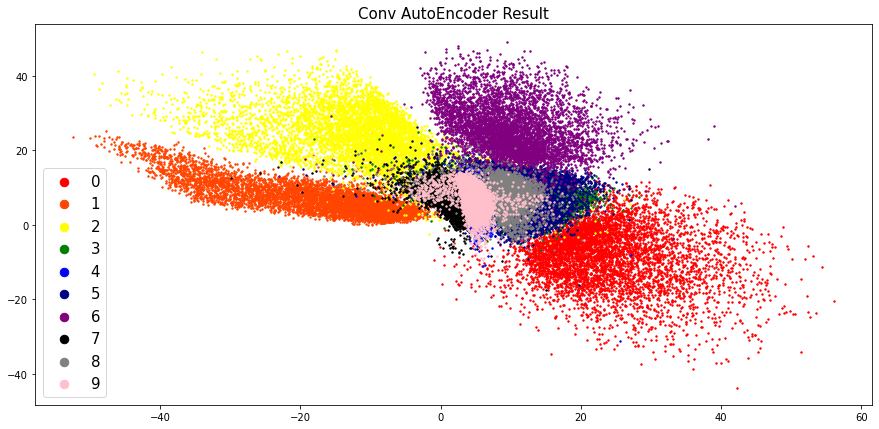

In [ ]:
import matplotlib.pyplot as plt

z_0 = z_conv_1[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_conv_1[train_labels==1]
z_2 = z_conv_1[train_labels==2]
z_3 = z_conv_1[train_labels==3]
z_4 = z_conv_1[train_labels==4]
z_5 = z_conv_1[train_labels==5]
z_6 = z_conv_1[train_labels==6]
z_7 = z_conv_1[train_labels==7]
z_8 = z_conv_1[train_labels==8]
z_9 = z_conv_1[train_labels==9]


plt.figure(figsize=(15,7))
plt.title('Conv AutoEncoder Result', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- 또한 z vecotr를 시각화 해보면, 앞의 Convolutional AE 보다 각 label에 대하여 discriminative한 학습을 했다고 볼 수 있다. 그럼에도 불구하고, 몇몇의 label들은 가운데 몰려 있다는 것을 확인할 수 있다.

## 2. GlobalAveragingPooling vs Fully-connected layer  


- 기존의 모델은 이미지의 size를 줄여가면서 정보를 channels에 저장한 후 GlobalAveragePooling을 통하여 latent vector를 생성했다. 이에 Flatten한 후 Dense 층을 쌓는것과 어떠한 차이가 있는지 확인하기 위해 동일한 조건하에 마지막 GAP layer 대신에 fully-connected layer 를 사용했다.

In [ ]:
conv_enc_2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)), # input_shape = (28,28,1)                                 
    tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), strides = (2,2), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides = (2,2), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = 256, kernel_size=(3,3), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_dim)
])

conv_dec_2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_dim,)),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Reshape(target_shape=(4,4,256)),
    tf.keras.layers.Conv2DTranspose(256, kernel_size=(3,3), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2DTranspose(128, kernel_size=(2,2), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides = (2,2), padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=(3,3), strides = (2,2), padding='same',  kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('sigmoid')
                                  
])

conv_ae_2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    conv_enc_2,
    conv_dec_2                          
])


In [ ]:
conv_enc_2.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 13, 13, 32)        320       
_________________________________________________________________
batch_normalization_147 (Bat (None, 13, 13, 32)        128       
_________________________________________________________________
activation_147 (Activation)  (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 6, 6, 128)         36992     
_________________________________________________________________
batch_normalization_148 (Bat (None, 6, 6, 128)         512       
_________________________________________________________________
activation_148 (Activation)  (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 4, 4, 256)       

In [ ]:
conv_dec_2.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_69 (Dense)             (None, 4096)              135168    
_________________________________________________________________
reshape_21 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_84 (Conv2DT (None, 6, 6, 256)         590080    
_________________________________________________________________
batch_normalization_150 (Bat (None, 6, 6, 256)         1024      
_________________________________________________________________
activation_150 (Activation)  (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_transpose_85 (Conv2DT (None, 7, 7, 128)       

In [ ]:
y_pred_conv_2 = conv_ae_2.predict(train_images,batch_size = 1024)
print('input  shape:', train_images.shape)
print('output shape:', y_pred_conv_2.shape)

input  shape: (60000, 28, 28, 1)
output shape: (60000, 28, 28, 1)


In [ ]:
def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.gca().set_title('real data')
  plt.imshow(np.reshape(train_images[idx],(28,28)))
  plt.subplot(122)
  plt.gca().set_title("Conv AE (with Fully-connected layer)")
  plt.imshow(np.reshape(y_pred_conv_2[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
## 학습 

print(np.shape(train_images))
conv_ae_2.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

conv_ae_2.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

(60000, 28, 28, 1)
Epoch 1/10
600/600 [==============================] - 15s 23ms/step - loss: 0.1564 - mae: 0.3646
Epoch 2/10
600/600 [==============================] - 14s 23ms/step - loss: 0.0849 - mae: 0.2545
Epoch 3/10
600/600 [==============================] - 14s 23ms/step - loss: 0.0625 - mae: 0.2029
Epoch 4/10
600/600 [==============================] - 14s 23ms/step - loss: 0.0529 - mae: 0.1733
Epoch 5/10
600/600 [==============================] - 14s 23ms/step - loss: 0.0479 - mae: 0.1542
Epoch 6/10
600/600 [==============================] - 14s 23ms/step - loss: 0.0451 - mae: 0.1410
Epoch 7/10
600/600 [==============================] - 14s 23ms/step - loss: 0.0431 - mae: 0.1313
Epoch 8/10
600/600 [==============================] - 14s 23ms/step - loss: 0.0415 - mae: 0.1241
Epoch 9/10
600/600 [==============================] - 14s 23ms/step - loss: 0.0403 - mae: 0.1179
Epoch 10/10
600/600 [==============================] - 14s 23ms/step - loss: 0.0394 - mae: 0.1131


- fully-connected layer를 사용한 Convolutional AE를 학습 시킨 결과 GAP layer에 비해 가중치가 많아 epochs당 시간이 더 오래 걸렸다. 하지만 성능은 보다 나아졌다.

In [ ]:
"""
학습된 Convolutional Autoencoder 통과
"""

y_pred_conv_ae_2 = conv_ae_2.predict(train_images, batch_size = 1024)


# encoder , decoder 다른 함수로 사용을 위함 
z_conv_2 = conv_enc_2.predict(train_images, batch_size = 1024)
y_pred_conv_2 = conv_dec_2.predict(z_conv_2, batch_size = 1024)
print(np.shape(train_images))
print(np.shape(z_conv_2))
print(np.shape(y_pred_conv_2))

(60000, 28, 28, 1)
(60000, 2)
(60000, 28, 28, 1)


In [ ]:
"""
Convolutional AE 결과 확인
"""



def io_imshow(idx):
  plt.figure(figsize = (15,7))
  print('GT label:', train_labels[idx])
  plt.subplot(141)
  plt.gca().set_title('real data')
  plt.imshow(np.reshape(train_images[idx],(28,28)))
  plt.subplot(142)
  plt.gca().set_title("Conv AE(Fully-Connected)")
  plt.imshow(np.reshape(y_pred_conv_ae_2[idx],(28,28)))
  plt.subplot(143)
  plt.gca().set_title("Conv AE(GAP)")
  plt.imshow(np.reshape(y_pred_conv_ae_1[idx],(28,28)))
  plt.subplot(144)
  plt.gca().set_title("Conv AE(Encoder : 256 -> 128 -> 32 -> 2)")
  plt.imshow(np.reshape(y_pred_conv_ae[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

- 결과를 확인해 보면 , GAP와 Fully-connected layer 둘다 어느정도 만들어 내지만, 큰 차이를 보이지 않고, 몇몇 idx에 대해서는 GAP layer가 잘 만들었고, Fully-Connected layer가 잘 만들었다. 하지만, GAP가 가중치도 더 적고, 학습속도도 빠르기 때문에 GAP layer가 보다 좋은 모델인것을 확인할 수 있다.

In [ ]:
def z_show(idx):
  print("Conv AutoEncoder",z_conv_2[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
u=widgets.FloatSlider(min=-10.0, max=10.0)
v=widgets.FloatSlider(min=-10.0, max=10.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  print(z_test)
  
  plt.title("Convolutional AE Fully - connected layer")
  img_gen_conv_2 = conv_dec_2(z_test)
  plt.imshow(np.reshape(img_gen_conv_2[0],(28,28)))
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

- Decoding도 준수하게 한다.

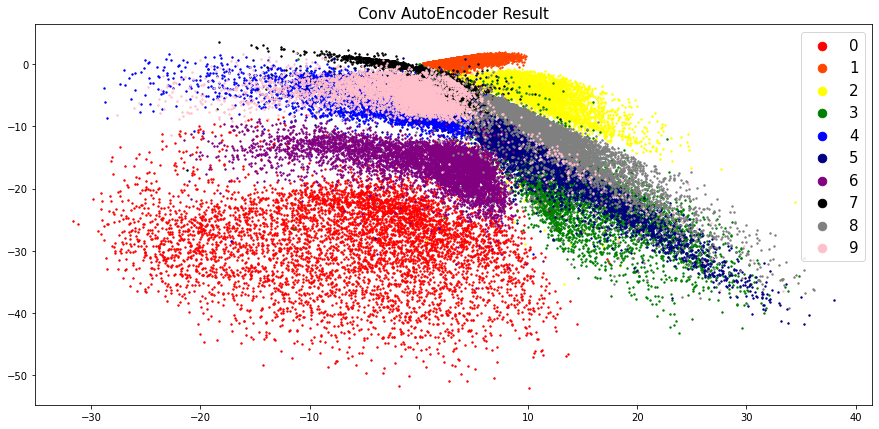

In [ ]:
z_0 = z_conv_2[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_conv_2[train_labels==1]
z_2 = z_conv_2[train_labels==2]
z_3 = z_conv_2[train_labels==3]
z_4 = z_conv_2[train_labels==4]
z_5 = z_conv_2[train_labels==5]
z_6 = z_conv_2[train_labels==6]
z_7 = z_conv_2[train_labels==7]
z_8 = z_conv_2[train_labels==8]
z_9 = z_conv_2[train_labels==9]


plt.figure(figsize=(15,7))
plt.title('Conv AutoEncoder Result', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- z vector를 시각화 해보면, 앞의 Convolutional AE 보다 각 label에 대하여 discriminative한 학습을 했지만 GAP를 사용한 Conv AE보다는 좋지 않다고 볼 수 있다.

## 3. Conv2Transpose vs Upsampling + Conv layer  

- 이미지를 upscaling하면서 학습하는 방법으로 신경망에서는 Conv2Transpose 또는 Upsampling + Conv layer를 사용한다. 이에 이 두 경우의 차이를 실험해보겠다.

In [ ]:
conv_enc_3 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)), # input_shape = (28,28,1)                                 
    tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), strides = (2,2), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size=(3,3), strides = (2,2), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = 256, kernel_size=(3,3), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters = n_dim, kernel_size=(4,4), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.GlobalAveragePooling2D()
])

conv_dec_3 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_dim,)),
    tf.keras.layers.Reshape(target_shape=(1,1,2)),
    tf.keras.layers.UpSampling2D((4,4)),
    tf.keras.layers.Conv2D(256, kernel_size=(4,4), strides = (1,1), padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(128, kernel_size=(2,2), strides = (1,1), padding='valid', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides = (1,1), padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(1, kernel_size=(4,4), strides = (1,1), padding='same',  kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('sigmoid')
                                  
])

conv_ae_3 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    conv_enc_3,
    conv_dec_3                          
])


In [ ]:
conv_enc_3.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 13, 13, 32)        320       
_________________________________________________________________
batch_normalization_196 (Bat (None, 13, 13, 32)        128       
_________________________________________________________________
activation_196 (Activation)  (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 6, 6, 128)         36992     
_________________________________________________________________
batch_normalization_197 (Bat (None, 6, 6, 128)         512       
_________________________________________________________________
activation_197 (Activation)  (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 4, 4, 256)       

In [ ]:
conv_dec_3.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_28 (Reshape)         (None, 1, 1, 2)           0         
_________________________________________________________________
up_sampling2d_24 (UpSampling (None, 4, 4, 2)           0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 4, 4, 256)         8448      
_________________________________________________________________
batch_normalization_199 (Bat (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_199 (Activation)  (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_25 (UpSampling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 7, 7, 128)       

- Conv2Transpose를 사용한 AE보다 가중치가 훨씬 낮은것을 확인할 수 있다. 이는 Conv2Transpose가 trainable한 parameters를 가지고 있으며, size를 늘린 후 pixel값에 대하여 학습을 진행하는 방식이기 때문이다. 하지만 Upsample2D는 단순히 size만 키우고 따로 trainable parameters가 존재하지 않는다. 

In [ ]:
y_pred_conv_3 = conv_ae_3.predict(train_images,batch_size = 1024)
print('input  shape:', train_images.shape)
print('output shape:', y_pred_conv_3.shape)

input  shape: (60000, 28, 28, 1)
output shape: (60000, 28, 28, 1)


In [ ]:
def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.gca().set_title('real data')
  plt.imshow(np.reshape(train_images[idx],(28,28)))
  plt.subplot(122)
  plt.gca().set_title("Conv AE (upsample)")
  plt.imshow(np.reshape(y_pred_conv_3[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
## 학습 

print(np.shape(train_images))
conv_ae_3.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

conv_ae_3.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

(60000, 28, 28, 1)
Epoch 1/10
600/600 [==============================] - 16s 25ms/step - loss: 0.1563 - mae: 0.3628
Epoch 2/10
600/600 [==============================] - 15s 25ms/step - loss: 0.0873 - mae: 0.2574
Epoch 3/10
600/600 [==============================] - 15s 25ms/step - loss: 0.0648 - mae: 0.2071
Epoch 4/10
600/600 [==============================] - 15s 25ms/step - loss: 0.0548 - mae: 0.1776
Epoch 5/10
600/600 [==============================] - 15s 25ms/step - loss: 0.0498 - mae: 0.1589
Epoch 6/10
600/600 [==============================] - 15s 25ms/step - loss: 0.0466 - mae: 0.1458
Epoch 7/10
600/600 [==============================] - 15s 25ms/step - loss: 0.0443 - mae: 0.1354
Epoch 8/10
600/600 [==============================] - 15s 25ms/step - loss: 0.0428 - mae: 0.1278
Epoch 9/10
600/600 [==============================] - 15s 25ms/step - loss: 0.0419 - mae: 0.1217
Epoch 10/10
600/600 [==============================] - 15s 25ms/step - loss: 0.0410 - mae: 0.1163


In [ ]:
"""
학습된 Convolutional Autoencoder 통과
"""

y_pred_conv_ae_3 = conv_ae_3.predict(train_images, batch_size = 1024)


# encoder , decoder 다른 함수로 사용을 위함 
z_conv_3 = conv_enc_3.predict(train_images, batch_size = 1024)
y_pred_conv_3 = conv_dec_3.predict(z_conv_3, batch_size = 1024)
print(np.shape(train_images))
print(np.shape(z_conv_3))
print(np.shape(y_pred_conv_3))

(60000, 28, 28, 1)
(60000, 2)
(60000, 28, 28, 1)


In [ ]:
"""
Convolutional AE 결과 확인
"""



def io_imshow(idx):
  plt.figure(figsize = (15,7))
  print('GT label:', train_labels[idx])
  plt.subplot(131)
  plt.gca().set_title('real data')
  plt.imshow(np.reshape(train_images[idx],(28,28)))
  plt.subplot(132)
  plt.gca().set_title("Conv AE(upsample)")
  plt.imshow(np.reshape(y_pred_conv_ae_3[idx],(28,28)))
  plt.subplot(133)
  plt.gca().set_title("Conv AE(conv2dTransepose)")
  plt.imshow(np.reshape(y_pred_conv_ae_1[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

결과를 확인해 보면 , Upsample와 Transpose layer 둘다 어느정도 만들어 내지만, 큰 차이를 보이지 않고, 몇몇 idx에 대해서는 Upsample layer 모델이 잘 만들었고, Conv2Transpose layer모델이 잘 만들었다. 

In [ ]:
def z_show(idx):
  print("Conv AutoEncoder",z_conv_3[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
u=widgets.FloatSlider(min=-10.0, max=10.0)
v=widgets.FloatSlider(min=-10.0, max=10.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  print(z_test)
  
  plt.title("Convolutional AE Fully - connected layer")
  img_gen_conv_3 = conv_dec_3(z_test)
  plt.imshow(np.reshape(img_gen_conv_3[0],(28,28)))
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

- z에 대하여도 decoding이 준수하다.

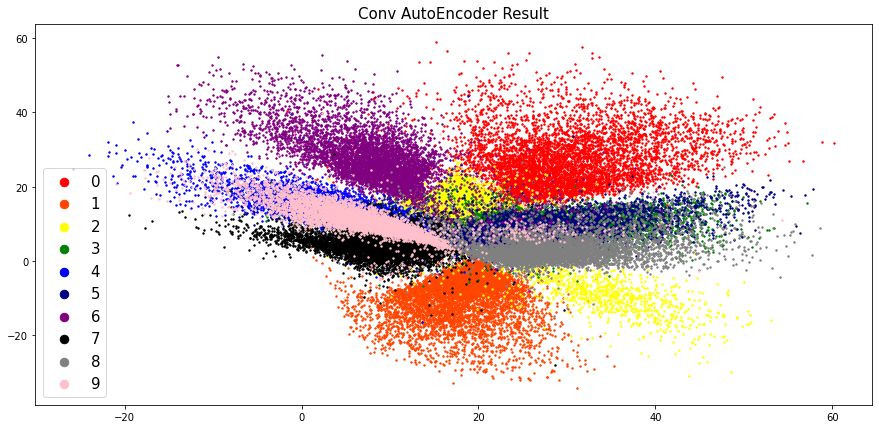

In [ ]:
z_0 = z_conv_3[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_conv_3[train_labels==1]
z_2 = z_conv_3[train_labels==2]
z_3 = z_conv_3[train_labels==3]
z_4 = z_conv_3[train_labels==4]
z_5 = z_conv_3[train_labels==5]
z_6 = z_conv_3[train_labels==6]
z_7 = z_conv_3[train_labels==7]
z_8 = z_conv_3[train_labels==8]
z_9 = z_conv_3[train_labels==9]


plt.figure(figsize=(15,7))
plt.title('Conv AutoEncoder Result', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- train image에 대하여 Encoding 결과인 z vector의 분포를 시각화해서 보았을때, 놀라운 결과를 볼 수 있다. 기존 다른 모델들에 비하여 label들에 따라 공간이 어느정도 구분되어 있는것을 확인할 수 있다. 즉 , discriminative한 학습을 했다고 볼 수 있다.

- MNIST 데이터를 보면, 숫자에 해당하는 pixel 값을 제외하고는 값이 존재하지 않기 때문에 학습을 통해 upscaling 하는 Conv2Transposed layer보다 이미지를 확대해서 conv layer로 학습하는 upsampling + conv layer가 더욱 효과적임을 확인할 수 있다. 